In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import os
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics._plot import confusion_matrix as cm
from sklearn.metrics import confusion_matrix
import faiss
from sklearn.utils import resample, shuffle

## Utils

In [2]:
def imageSet(dirActive):
    def getCv2ImgAtIndex(index, labelsCsv):
        ts = labelsCsv['timestamp'][index]
        if not os.path.exists(f'{dirActive}/images/img_{ts}.jpeg'):
             return np.array([])
        img = cv2.resize(cv2.imread(f'{dirActive}/images/img_{ts}.jpeg'),(80,60))
        return img
    labelsCsv = pd.read_csv(f'{dirActive}/labels.csv')
    labelsThatExists = [i for i in range(len(labelsCsv)) if os.path.exists(f'{dirActive}/images/img_{labelsCsv["timestamp"][i]}.jpeg') and labelsCsv['forward/backward'][i] == 1]
    imageArray = np.array([getCv2ImgAtIndex(i,labelsCsv) for i in labelsThatExists])
    leftRightArray = np.array([labelsCsv['left/right'][i] for i in labelsThatExists])
    return imageArray, leftRightArray, labelsCsv

def processedImageSet(imageSet, labelSet, processFunc):
    imageArray = np.array([processFunc(i) for i in imageSet])
    flatImageArray = np.array([image.flatten() for image in imageArray])
    return flatImageArray, labelSet, imageArray, imageSet

def bmxr(im, x=1.5):
    b = im[:,:,0]
    r = im[:,:,2]
    return cv2.subtract(b,cv2.multiply(r,x))

def thresholdIm(im, low=50, high=255):
    e,im = cv2.threshold(im, low, high, cv2.THRESH_BINARY)
    return im

def dispIm(im, label="pic"):
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im_rgb)
    plt.title(label)
    plt.show()

def dispGSIm(im, label='pic'):
    plt.imshow(im, cmap='gray', vmin = 0, vmax = 255,interpolation='none')
    plt.title(label)
    plt.show()

## Get train and test set

In [3]:
train_u_images, train_u_labels, labelsCsv_train = imageSet('../data/train_data/dataTrackV2_4/')
test_images, test_labels, labelsCsv_test = imageSet('../data/test_data/dataTrackV2_5/')

## Balance the sampling in the training set

In [4]:
counts = np.bincount(train_u_labels + 1)
print(counts)
dominantClass = 0
dominantClassCount = counts[dominantClass + 1]
print(f'dominant class ({dominantClass}) has {dominantClassCount} samples.')
dominantIndices = np.where(train_u_labels == dominantClass)[0]
X_straight = train_u_images[dominantIndices]
y_straight = train_u_labels[dominantIndices]

X_left, y_left = resample(train_u_images[train_u_labels == -1], train_u_labels[train_u_labels == -1],
                                 replace=True,     # sample with replacement
                                 n_samples=dominantClassCount,    # to match majority class
                                 random_state=42) # reproducible results

X_right, y_right = resample(train_u_images[train_u_labels == 1], train_u_labels[train_u_labels == 1],
                                 replace=True,     # sample with replacement
                                 n_samples=dominantClassCount,    # to match majority class
                                 random_state=42) # reproducible results

train_labels = np.concatenate((y_left,y_straight,y_right))
train_images = np.concatenate((X_left, X_straight, X_right))
train_images, train_labels = shuffle(train_images, train_labels, random_state=42)
counts = np.bincount(train_labels + 1)
print(counts)

[ 2158 13609  1547]
dominant class (0) has 13609 samples.
[13609 13609 13609]


## Process the data

In [5]:
def processImage(im):    
    im = bmxr(im,1.25)
    im = thresholdIm(im,8,255)
    
    return im

X_test, y_test, X_test_images, X_test_originals = processedImageSet(test_images, test_labels, processImage)
X_train, y_train, X_train_images, X_train_originals = processedImageSet(train_images, train_labels, processImage)

In [6]:
import random

def displayRandom(ims, originals, k=1):
    for i in range(k):
        ind = random.randint(0, len(ims))
        dispIm(originals[ind],f'og @{ind}')
        dispIm(ims[ind], f'edit @{ind}')

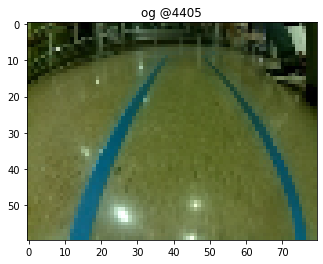

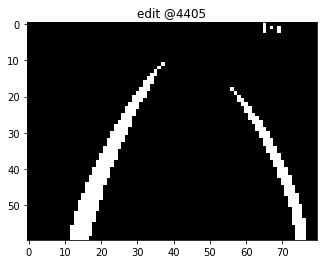

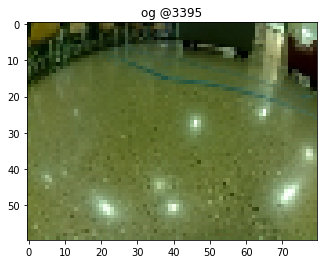

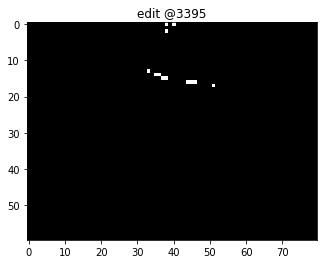

In [7]:
displayRandom(X_test_images, X_test_originals)
displayRandom(X_train_images, X_train_originals)

# K-NearestNeighbours

In [140]:
class FaissKNeighbors:
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict(self, X):
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices] + 1
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes]) - 1
        return predictions

In [141]:
def runKNN(k):
    knn = FaissKNeighbors(k=k)
    knn.fit(X_train, y_train)
    y_predict = knn.predict(X_test)
    acc = accuracy_score(y_test, y_predict)
    bacc = balanced_accuracy_score(y_test, y_predict)
    print(f'k={k} test accuracy: {acc:.3f} bacc: {bacc:.3f}')
    matrix = confusion_matrix(y_test, y_predict)
    disp=cm.ConfusionMatrixDisplay(confusion_matrix=matrix,
                               display_labels=['-1','0','1'])
    disp.plot(include_values=True, cmap=plt.cm.Blues);

k=20 test accuracy: 0.712 bacc: 0.712


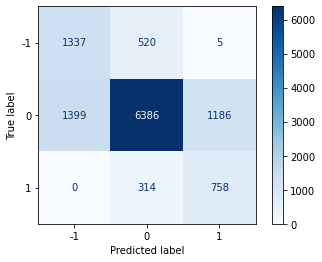

In [143]:
runKNN(20)

k=1 test accuracy: 0.776 bacc: 0.601


KeyboardInterrupt: 

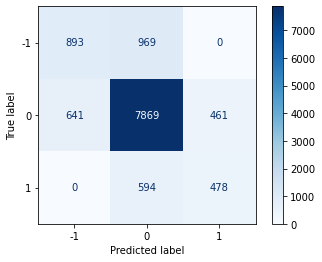

In [142]:
for i in range(1,20):
    runKNN(i)
    pass

k=20 test accuracy: 0.680 bacc: 0.718
k=21 test accuracy: 0.677 bacc: 0.720
k=22 test accuracy: 0.679 bacc: 0.725
k=23 test accuracy: 0.679 bacc: 0.727
k=24 test accuracy: 0.672 bacc: 0.728
k=25 test accuracy: 0.669 bacc: 0.726
k=26 test accuracy: 0.669 bacc: 0.729
k=27 test accuracy: 0.665 bacc: 0.729
k=28 test accuracy: 0.663 bacc: 0.729
k=29 test accuracy: 0.659 bacc: 0.728
k=30 test accuracy: 0.659 bacc: 0.731
k=31 test accuracy: 0.657 bacc: 0.731


KeyboardInterrupt: 

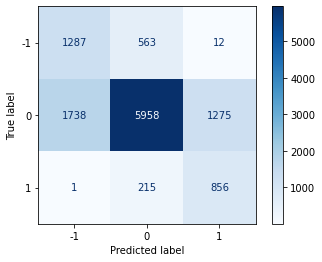

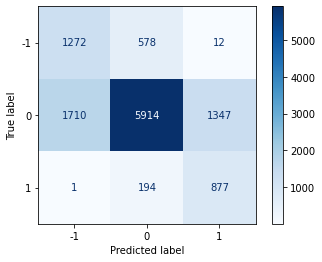

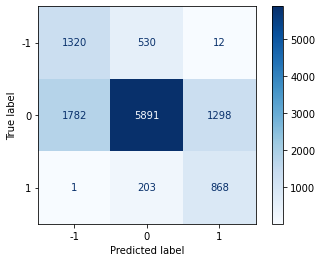

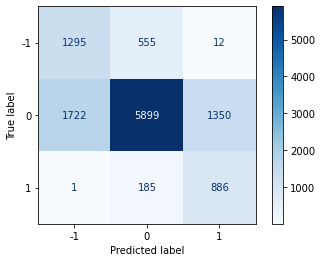

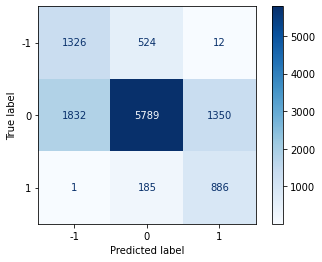

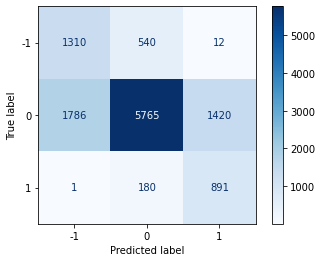

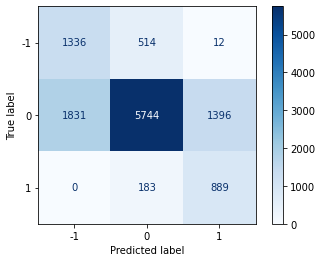

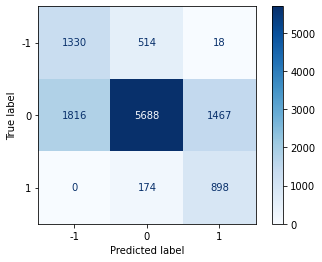

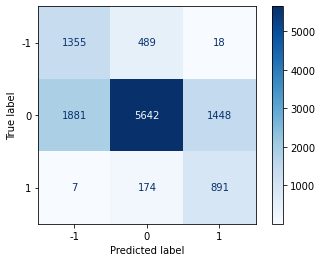

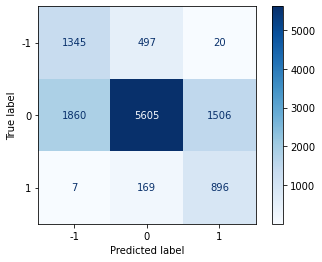

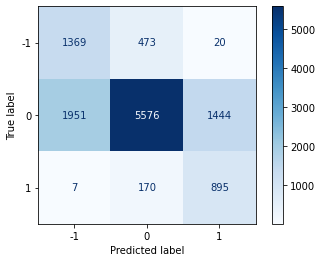

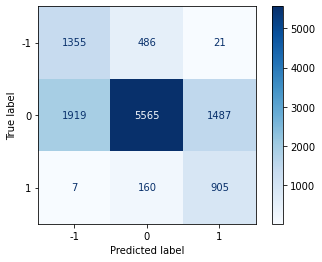

In [121]:
for i in range(20,40):
    runKNN(i)
    pass

# Keras

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [11]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [121]:
from keras import backend as K
K.clear_session()
history1 = None
model = None

In [124]:
model = keras.Sequential(
    [
        keras.Input(shape=(4800,)),
        layers.Dropout(.4),
        layers.Dense(64, activation="relu", name="layer55"),
        layers.Dropout(.4),
        layers.Dense(3, name="layer6", activation="softmax"),
    ]
)

In [125]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 4800)              0         
_________________________________________________________________
layer55 (Dense)              (None, 64)                307264    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
layer6 (Dense)               (None, 3)                 195       
Total params: 307,459
Trainable params: 307,459
Non-trainable params: 0
_________________________________________________________________


In [126]:
# loss_fn = keras.losses.categorical_crossentropy()
# opt = keras.optimizers.SGD(learning_rate=0.005)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'mse'])

In [127]:
# Call model on a test input
y = model(X_test)
y

<tf.Tensor: shape=(11905, 3), dtype=float32, numpy=
array([[9.9999952e-01, 1.7023754e-36, 4.3131226e-07],
       [8.0053241e-04, 0.0000000e+00, 9.9919945e-01],
       [9.9999821e-01, 0.0000000e+00, 1.8337556e-06],
       ...,
       [1.0000000e+00, 7.6464870e-34, 3.6238459e-09],
       [1.0000000e+00, 7.6464870e-34, 3.6238459e-09],
       [1.0000000e+00, 7.6464870e-34, 3.6238459e-09]], dtype=float32)>

In [128]:
from sklearn.preprocessing import OneHotEncoder
esc = OneHotEncoder()
esc.fit(np.array([-1,0,1]).reshape(-1, 1))
y_train_os = esc.transform(y_train.reshape(-1,1)).toarray()
y_test_os = esc.transform(y_test.reshape(-1,1)).toarray()
# es = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='auto',patience=10)

In [129]:
n_epochs = 1
history1 = model.fit((X_train / 255), y_train_os, validation_split=0.1, batch_size=1, epochs=n_epochs, verbose=1)

36744/36744 [==============================] - 31s 848us/step - loss: 0.4947 - accuracy: 0.8056 - mse: 0.0961 - val_loss: 0.3407 - val_accuracy: 0.8687 - val_mse: 0.0668


test accuracy: 0.878 bacc: 0.878


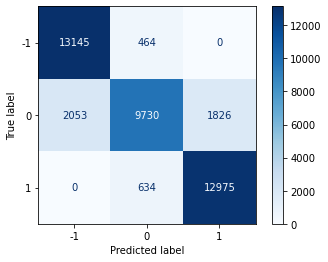

In [130]:
y_train_pred_out = model.predict(X_train/255)
y_train_pred = np.array([raw.argmax() - 1 for raw in y_train_pred_out])
acc = accuracy_score(y_train, y_train_pred)
bacc = balanced_accuracy_score(y_train, y_train_pred)
print(f'test accuracy: {acc:.3f} bacc: {bacc:.3f}')
matrix = confusion_matrix(y_train, y_train_pred)
disp=cm.ConfusionMatrixDisplay(confusion_matrix=matrix,
                               display_labels=['-1','0','1'])
disp.plot(include_values=True, cmap=plt.cm.Blues);

test accuracy: 0.712 bacc: 0.782


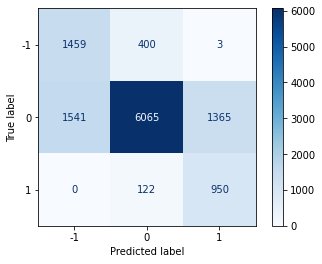

In [131]:
y_test_pred_out = model.predict(X_test/255)
y_test_pred = np.array([raw.argmax() - 1 for raw in y_test_pred_out])
acc = accuracy_score(y_test, y_test_pred)
bacc = balanced_accuracy_score(y_test, y_test_pred)
print(f'test accuracy: {acc:.3f} bacc: {bacc:.3f}')
matrix = confusion_matrix(y_test, y_test_pred)
disp=cm.ConfusionMatrixDisplay(confusion_matrix=matrix,
                               display_labels=['-1','0','1'])
disp.plot(include_values=True, cmap=plt.cm.Blues);

pred
1
true
0


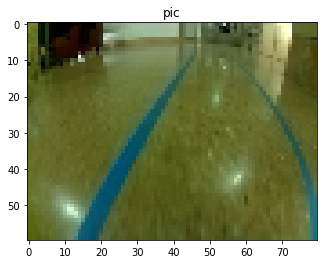

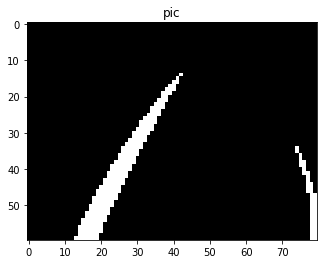

In [149]:
errors = np.where(y_test_pred != y_test)[0]
i = np.random.choice(errors)
print("pred")
print(y_test_pred[i])
print('true')
print(y_test[i])
dispIm(X_test_originals[i])
dispIm(X_test_images[i])

In [150]:
model.save('../models/daniel_dense.h5')

# CNN

In [235]:
K.clear_session()
history2 = None
model2 = None

In [236]:
X_test_originals.shape

(11905, 60, 80, 3)

In [237]:
model2 = keras.Sequential()
model2.add(keras.layers.Conv2D(8, (5, 5), activation='relu'))
model2.add(keras.layers.MaxPooling2D((3, 3)))
model2.add(keras.layers.Conv2D(16, (3, 3), activation='relu'))
model2.add(keras.layers.MaxPooling2D((2, 2)))
model2.add(keras.layers.Conv2D(8, (2, 2), activation='relu'))
model2.add(keras.layers.Flatten())
model2.add(layers.Dropout(.4))
model2.add(keras.layers.Dense(64, activation='relu'))
model2.add(layers.Dropout(.4))
model2.add(layers.Dense(3, activation='softmax'))

In [238]:
# model2.summary()

In [239]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'mse'])

In [240]:
X_train_images.shape

(40827, 60, 80)

In [266]:
n_epochs = 1
X_t = X_train_images.reshape(-1,60,80,1)
history2 = model2.fit((X_t / 255), y_train_os, validation_split=0.1, batch_size=1, epochs=n_epochs, verbose=1)

36744/36744 [==============================] - 55s 2ms/step - loss: 0.3855 - accuracy: 0.8402 - mse: 0.0783 - val_loss: 0.3271 - val_accuracy: 0.8577 - val_mse: 0.0683


[[2.2543368e-06 9.9995065e-01 4.7118469e-05]
 [4.3169206e-07 9.9992990e-01 6.9657188e-05]
 [2.0590882e-05 9.9983931e-01 1.3999557e-04]
 ...
 [8.1140471e-01 1.8847135e-01 1.2391325e-04]
 [8.1140471e-01 1.8847135e-01 1.2391325e-04]
 [8.1140471e-01 1.8847135e-01 1.2391325e-04]]
test accuracy: 0.699 bacc: 0.795


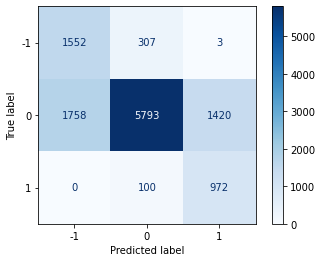

In [267]:
y_test_pred_out = model2.predict(X_test_images.reshape(-1,60,80,1)/255)
print(y_test_pred_out)
y_test_pred = np.array([raw.argmax() - 1 for raw in y_test_pred_out])
acc = accuracy_score(y_test, y_test_pred)
bacc = balanced_accuracy_score(y_test, y_test_pred)
print(f'test accuracy: {acc:.3f} bacc: {bacc:.3f}')
matrix = confusion_matrix(y_test, y_test_pred)
disp=cm.ConfusionMatrixDisplay(confusion_matrix=matrix,
                               display_labels=['-1','0','1'])
disp.plot(include_values=True, cmap=plt.cm.Blues);

pred
1
true
0


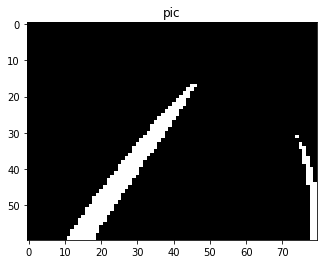

In [273]:
errors = np.where(y_test_pred != y_test)[0]
i = np.random.choice(errors)
print("pred")
print(y_test_pred[i])
print('true')
print(y_test[i])
dispIm(X_test_images[i])

In [247]:
model2.save('../models/daniel_cnn_bmxr_v1.h5')